<a href="https://colab.research.google.com/github/arafMustavi/SPitch/blob/main/RecordedAudio2banglaText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transcribe

[ Following the tutorial : https://realpython.com/python-speech-recognition/ ]

Dataset for Speech Recognition : 

[http://www.voiptroubleshooter.com/open_speech/index.html]

Speech Recognition | Library Installation

In [1]:
!pip install SpeechRecognition

Import and Version Check

In [2]:
import speech_recognition as sr
sr.__version__

'3.8.1'

## Recognizer Instance

Each Recognizer instance has seven methods for recognizing speech from an audio source using various APIs. These are:

- recognize_bing(): Microsoft Bing Speech

- recognize_google(): Google Web Speech API

- recognize_google_cloud(): Google Cloud Speech - requires installation of the
google-cloud-speech package

- recognize_houndify(): Houndify by SoundHound

- recognize_ibm(): IBM Speech to Text

- recognize_sphinx(): CMU Sphinx - requires installing PocketSphinx

- recognize_wit(): Wit.ai

of the seven, only recognize_sphinx() works offline with the CMU Sphinx engine. The other six all require an internet connection.

In [3]:
recog = sr.Recognizer()

Supported File Types

Currently, SpeechRecognition supports the following file formats:

- WAV: must be in PCM/LPCM format

- AIFF

- AIFF-C

- FLAC: must be native FLAC format; OGG-FLAC is not supported

In [4]:
#  WILL Throw and Error

# recog.recognize_google()

# How could something be recognized from nothing?

# **Working With Microphones**

Installing PyAudio
The process for installing PyAudio will vary depending on your operating system.

In colab, you can install PyAudio with pip:

In [5]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip3 install pyaudio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.1.3-5ubuntu0.5).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Fetched 184 kB in 1s (300 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 145480 files and directories currently installed.)
Preparing to 

# **Record Audio from MIC**

Following the Code [ https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/ ]

In [6]:
!pip install ffmpeg-python

In [7]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [8]:
# RUNNING THIS CODE BLOCK WILL RECORD THE AUDIO
recordedaudio, sr = get_audio()

In [9]:
import matplotlib.pyplot as plt

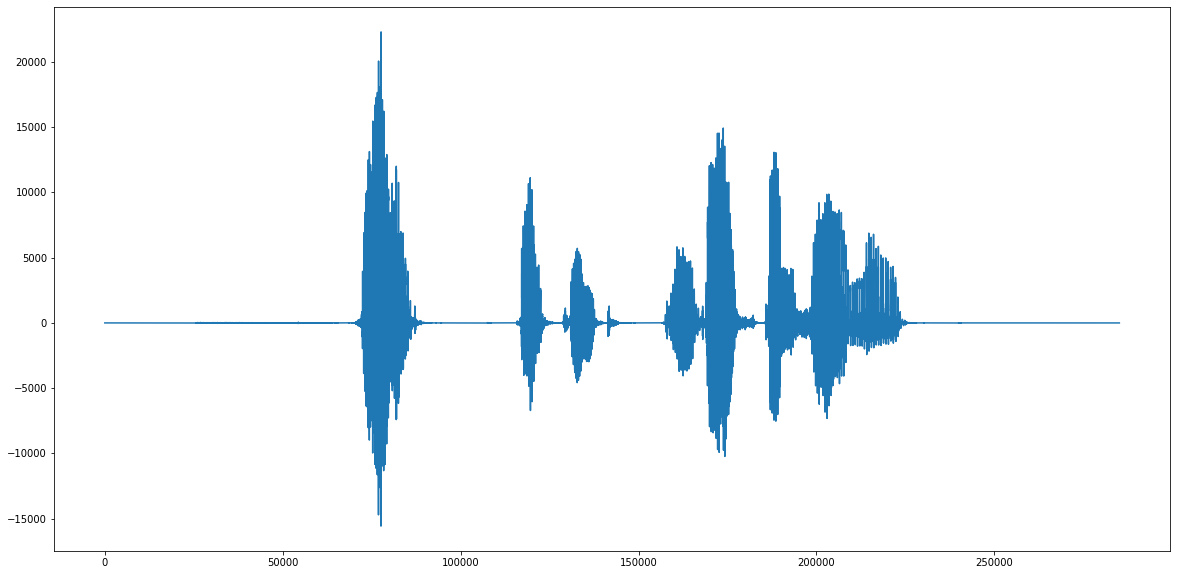

In [10]:
plt.figure(figsize=(20,10))
plt.plot(recordedaudio)
plt.show()

# **Congratulations! You have recorded the First Clip of your Life!**



# **Convert the Audio To Text**


Work Step :
- Save the recorded AUDIO into a wav file 
- Convert the WAV file to Text

[https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html ] 

[https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/]

In [11]:
type(recordedaudio)

numpy.ndarray

In [12]:
!pip install SpeechRecognition

In [13]:
import speech_recognition as sr
sr.__version__

'3.8.1'

In [14]:
recog = sr.Recognizer()

In [15]:
from scipy.io.wavfile import write
samplerate = 44100; fs = 100
# t = np.linspace(0., 1., samplerate)
# amplitude = np.iinfo(np.int16).max
# data = amplitude * np.sin(2. * np.pi * fs * t)
write("recordedSound.wav", samplerate, recordedaudio)

In [16]:

# inputAudio = sr.AudioFile('OSR_us_000_0010_8k.wav')
# inputAudio = recordedaudio
inputAudio = sr.AudioFile("recordedSound.wav")

with inputAudio as source:
    audio = recog.record(source)

In [17]:
result = recog.recognize_google(audio,language="bn-BD")
# result = recog.recognize_google(audio)
result

'হাই থ্যাঙ্ক ইউ গাইস ক্যান ইউ হিয়ার মি'

# **Congratulations! You’ve just transcribed your first audio file!**
